<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Convolutional Neural Network (GRU)

###Install dependencies

In [1]:
!pip install scikeras
!pip install bayesian-optimization
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.8 MB/s eta 0:00:00


###Load Libraries

In [2]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Dense, Dropout
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score
from scikeras.wrappers import KerasRegressor
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel, RandomSearch, Hyperband, BayesianOptimization
from keras.callbacks import EarlyStopping
from time import time
import pickle

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

###Define Functions to Facilitate Metrics Evaluation

In [3]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [4]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/main/Cleaned_data/FS_2.csv'
df = read_csv(path)
df.head()

,date,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
0,12/1/10,323,455,3102.61,423.45,844.0,468.0,578.0
1,1/1/11,345,546,3100.45,415.85,799.0,485.0,557.0
2,2/1/11,362,595,3199.41,410.77,718.0,466.0,552.0
3,3/1/11,376,636,3281.67,414.82,614.0,442.0,574.0
4,4/1/11,383,738,3261.65,451.04,619.0,429.0,595.0


In [5]:
df['date']=pd.to_datetime(df['date'])
#del df['date']

In [6]:
df.set_index('date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2010-12-01 to 2021-03-01
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cpo_pri  124 non-null    int64  
 1   cno_pri  124 non-null    int64  
 2   oli_pri  124 non-null    float64
 3   rps_pri  124 non-null    float64
 4   pno_pri  124 non-null    float64
 5   sbo_pri  124 non-null    float64
 6   sfo_pri  124 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 7.8 KB


In [7]:
df.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


<Figure size 1800x720 with 0 Axes>

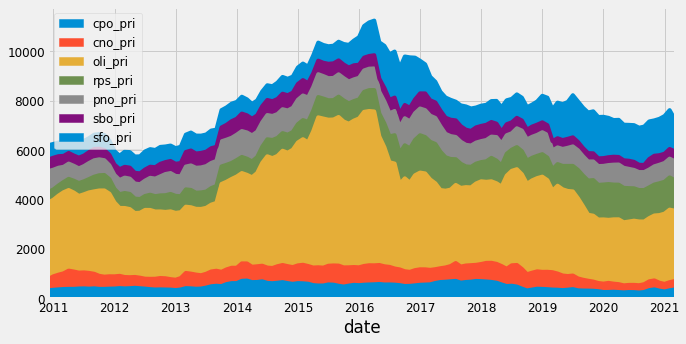

In [8]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('date');
ax.legend(fontsize=12);

##**Convolutional Neural Network Forecasting Technique (GRU)**

###**Split Data into Train Test Segments**

In [9]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 99
Test size: 25


In [10]:
split_date = '2019-02'
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

99 days of training data 
 25 days of testing data 


In [11]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

99 25


In [12]:
print(train.shape)
train.head()

(99, 7)


,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


###Rescaling Training Data

In [13]:
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'oli_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'sfo_pri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,0.112288,0.140918,0.010736,0.528090,0.253193,0.023302
2011-01-01,345,0.305085,0.140327,0.004301,0.443820,0.306536,0.009321
2011-02-01,362,0.408898,0.167408,0.000000,0.292135,0.246917,0.005992
2011-03-01,376,0.495763,0.189919,0.003429,0.097378,0.171609,0.020639
2011-04-01,383,0.711864,0.184440,0.034095,0.106742,0.130817,0.034621


In [14]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

date
2010-12-01    0.0100
2011-01-01    0.0650
2011-02-01    0.1075
2011-03-01    0.1425
2011-04-01    0.1600
Name: cpo_pri, dtype: float64

In [15]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2019-03-01,354,0.637712,0.194855,0.382454,0.381292,-0.039662,0.493342
2019-04-01,348,0.533898,0.264388,0.393951,0.213633,-0.054975,0.597870
2019-05-01,332,0.400424,0.246417,0.453802,0.235262,-0.092159,0.606525
2019-06-01,349,0.317797,0.234308,0.509834,0.320749,-0.074743,0.631824
2019-07-01,372,0.313559,0.223422,0.526454,0.426610,-0.066114,0.773462


In [16]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

date
2019-03-01    0.0875
2019-04-01    0.0725
2019-05-01    0.0325
2019-06-01    0.0750
2019-07-01    0.1325
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [17]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(96, 3, 7) (96,)


In [ ]:
#test_lag = test[1:23]
#len(test) - 1

In [ ]:
#decrement naturally.
#shifted = test.set_index(["date"]).unstack().shift(3).stack()

In [19]:
GRU_model = tf.keras.Sequential()
GRU_model.add(tf.keras.layers.GRU(64, activation='tanh', input_shape=(X_test.shape[1], X_test.shape[2])))
GRU_model.add(tf.keras.layers.Dense(64, activation='tanh'))
GRU_model.add(tf.keras.layers.Dense(1))

# compile model using adam
GRU_model.compile(optimizer='adam',loss='mse',metrics=['mse'])
# model training
history = GRU_model.fit(X_train, y_train, epochs=100, batch_size = 64, validation_split=0.2) #epochs = 30, batch_size = 60

# model evaluation
GRU_model.evaluate(X_test, y_test)


#GRU_model.compile(loss='mse', optimizer='adam')
#GRU_model.summary()
#bst -> epochs = 300, batch_size = 128, RMSE = 32
#bst -> epochs = 350, batch_size = 100, RMSE = 36
#bst -> epochs = 400, batch_size = 128, RMSE = 39

Epoch 1/100
2/2 [==============================] - 8s 1s/step - loss: 0.2980 - mse: 0.2980 - val_loss: 0.2374 - val_mse: 0.2374
Epoch 2/100
2/2 [==============================] - 0s 73ms/step - loss: 0.1021 - mse: 0.1021 - val_loss: 0.0934 - val_mse: 0.0934
Epoch 3/100
2/2 [==============================] - 0s 96ms/step - loss: 0.0337 - mse: 0.0337 - val_loss: 0.0667 - val_mse: 0.0667
Epoch 4/100
2/2 [==============================] - 0s 89ms/step - loss: 0.0594 - mse: 0.0594 - val_loss: 0.0783 - val_mse: 0.0783
Epoch 5/100
2/2 [==============================] - 0s 72ms/step - loss: 0.0895 - mse: 0.0895 - val_loss: 0.0715 - val_mse: 0.0715
Epoch 6/100
2/2 [==============================] - 0s 74ms/step - loss: 0.0773 - mse: 0.0773 - val_loss: 0.0590 - val_mse: 0.0590
Epoch 7/100
2/2 [==============================] - 0s 77ms/step - loss: 0.0465 - mse: 0.0465 - val_loss: 0.0611 - val_mse: 0.0611
Epoch 8/100
2/2 [==============================] - 0s 138ms/step - loss: 0.0269 - mse: 0.026

[0.007562777027487755, 0.007562777027487755]

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


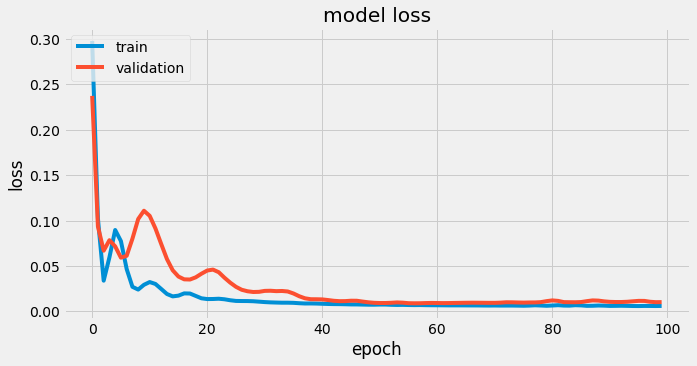

In [20]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
mse_GRU = GRU_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 31ms/step - loss: 0.0076 - mse: 0.0076


####Baseline MSE = 0.01660

In [22]:
GRU_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                14016     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,241
Trainable params: 18,241
Non-trainable params: 0
_________________________________________________________________


###Predict the Test without Hyperparameter Tuning

In [23]:
y_pred = GRU_model.predict(X_test)
y_pred

1/1 [==============================] - 0s 451ms/step


array([[ 0.04321732],
       [ 0.04567152],
       [ 0.07345565],
       [ 0.04087729],
       [ 0.01193969],
       [-0.00105167],
       [-0.00642957],
       [-0.03423236],
       [-0.08494218],
       [-0.11282637],
       [-0.11039161],
       [-0.11976198],
       [-0.13909054],
       [-0.1274358 ],
       [-0.12438261],
       [-0.15502894],
       [-0.16234438],
       [-0.02870931],
       [ 0.0834837 ],
       [ 0.07395187],
       [ 0.01170788],
       [ 0.02099521]], dtype=float32)

In [24]:
y_pred.reshape(1,-1)

array([[ 0.04321732,  0.04567152,  0.07345565,  0.04087729,  0.01193969,
        -0.00105167, -0.00642957, -0.03423236, -0.08494218, -0.11282637,
        -0.11039161, -0.11976198, -0.13909054, -0.1274358 , -0.12438261,
        -0.15502894, -0.16234438, -0.02870931,  0.0834837 ,  0.07395187,
         0.01170788,  0.02099521]], dtype=float32)

###Invert Transformed Data

In [25]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[336.28693 337.26862 348.38226 335.35092 323.77588 318.57935 316.4282
  305.30707 285.02313 273.86945 274.84335 271.0952  263.3638  268.0257
  269.24695 256.98843 254.06224 307.5163  352.3935  348.58075 323.68314
  327.39807]]


###Plot History, Actual and Predicted Value

In [26]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [27]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [28]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([336.28693, 337.26862, 348.38226, 335.35092, 323.77588, 318.57935,
       316.4282 , 305.30707, 285.02313, 273.86945, 274.84335, 271.0952 ,
       263.3638 , 268.0257 , 269.24695, 256.98843, 254.06224, 307.5163 ,
       352.3935 , 348.58075, 323.68314, 327.39807], dtype=float32)

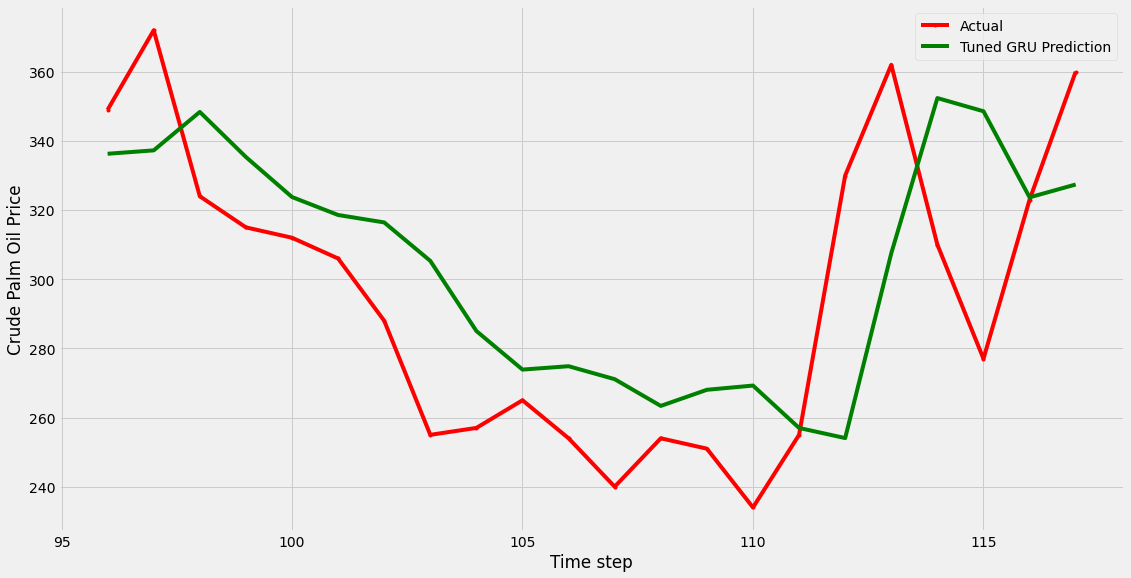

In [29]:
plt.figure(figsize=(17,9))
#plt.grid()
#plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='red', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='green', label="Tuned GRU Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
ax.grid()
#plt.grid()
#plt.show();

###Evaluate GRU Model Accuracy

In [30]:
MAE_GRU = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the GRU Model is:', MAE_GRU)

MDA_GRU = mda(y_test_inv, y_pred_inv)
print('MDA value of the GRU Model is:', MDA_GRU)

MAPE_GRU = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the GRU Model is:', MAPE_GRU)

RMSE_GRU = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the GRU Model is:', RMSE_GRU)

MSE_GRU = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the GRU Model is:', MSE_GRU)

#EVS_GRU = explained_variance_score(y_test_inv, y_pred_inv)
#print('EVS score of the GRU Model is:', EVS_GRU)

MAE value of the GRU Model is: 28.42749647660689
MDA value of the GRU Model is: 0.47619047619047616
MAPE value of the GRU Model is: 9.682798015284252
RMSE value of the GRU Model is: 34.785694085666975
MSE value of the GRU Model is: 1210.0445130216065


###Tuning GRU with Keras Tuner

Define A Model-Building Class

In [31]:
#class ANNhypermodel(HyperModel):
class GRUHyperModel(HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape= input_shape
        
    def build(self, hp):
        model= keras.Sequential()
        
        # Tune the number of units in the first Dense layer
        # Defining dense units as a close approx to the original neural network to perform a fair comparision!
      
        hp_units_1= hp.Int('units_1', min_value=128, max_value= 160, step=32)
        hp_units_2= hp.Int('units_2', min_value=64, max_value= 128, step=32)
        hp_units_3= hp.Int('units_3', min_value=32, max_value= 64, step=16)
        hp_units_4= hp.Int('units_4', min_value=16, max_value= 32, step=8)

        model.add(keras.layers.Dense(units=hp_units_1, activation='tanh', input_shape= self.input_shape))
        model.add(keras.layers.Dense(units=hp_units_2, activation='tanh'))
        model.add(keras.layers.Dense(units=hp_units_3, activation='tanh'))
        model.add(keras.layers.Dense(units=hp_units_4, activation='tanh'))
        model.add(keras.layers.Dense(1))
        #Tune the dropout
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )
        
        # Tune the epoch for the optimizer

        #batch_size = hp.Int('batch_size',8,16,24,32,40,48,56,64,72,80,88,96, step=8)
        
        optimizers = hp.Choice('optimizer',values=['rmsprop','adam', 'AdamW', 'nadam','sgd','adadelta','adagrad'])

        hp_dense_activation = hp.Choice('activation',values=['relu', 'tanh', 'sigmoid', 'linear', 'Softmax', 'ELU', 'linear'])

        # Tune the batch size for the optimizer 
        hp_batch_size = hp.Int('batch_size', min_value = 8, max_value = 96, step = 8, default=8)
        
        # Tune the epoch for the optimizer
        hp_epoch = hp.Int('epoch', min_value = 5, max_value = 100, step = 5, default=5)

        # Tune the epoch for the momentum
        hp_momentum = hp.Float('momentum', min_value = 0.8, max_value = 0.99, step = 0.01, default=0.9)

        # Tune the epoch for the decay
        hp_decay = hp.Float('decay', min_value = 1e-9, max_value = 1e-3, step= 0.0001, default=1e-7)

        # Tune the learning rate for the optimizer 
        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default= 0.0005)
       # -------------------------------------------------------
        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mae','mse']
                     )

        return model

#hypermodel= ANNhypermodel(input_shape = (X_test.shape[1], X_test.shape[2]))
hypermodel = GRUHyperModel(input_shape = (X_test.shape[1], X_test.shape[2]))

###Build Random Search Tuner

In [32]:
tuner_rs = RandomSearch(
            hypermodel,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True
        )

###Run Random Search

In [33]:
tuner_rs.search(X_train, y_train, epochs=16, validation_split=0.2, verbose=0)

###Evaluate Random Search

In [34]:
best_model = tuner_rs.get_best_models(num_models=1)[0]
mse_rs = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 451ms/step - loss: 0.1215 - mae: 0.3291 - mse: 0.1215


####Random Search MSE = 0.2369

In [35]:
best_params = tuner_rs.get_best_hyperparameters()

best_params[0].values

{'units_1': 160,
 'units_2': 128,
 'units_3': 64,
 'units_4': 32,
 'dropout': 0.1,
 'optimizer': 'sgd',
 'activation': 'linear',
 'batch_size': 64,
 'epoch': 70,
 'momentum': 0.8700000000000001,
 'decay': 0.00010000100000000001,
 'learning_rate': 0.0010874771484415556}

###Build Bayesian Optimization

In [36]:
tuner_bo = BayesianOptimization(
            hypermodel,
            objective='val_mse',
            max_trials=10,
            seed=42,
            executions_per_trial=2,
            directory='bo'
        )

###Run Bayesian Optimization

In [37]:
tuner_bo.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)

best_model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 439ms/step - loss: 0.2173 - mae: 0.4528 - mse: 0.2173


###Bayesian Optimization Search MSE = 0.3562

###Evaluate Bayesian Optimization

In [38]:
best_params = tuner_bo.get_best_hyperparameters()

best_params[0].values

{'units_1': 128,
 'units_2': 64,
 'units_3': 48,
 'units_4': 32,
 'dropout': 0.25,
 'optimizer': 'adadelta',
 'activation': 'sigmoid',
 'batch_size': 24,
 'epoch': 40,
 'momentum': 0.8700000000000001,
 'decay': 0.00010000100000000001,
 'learning_rate': 0.001453129317743269}

In [39]:
best_model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 469ms/step - loss: 0.2173 - mae: 0.4528 - mse: 0.2173


###Build HYPERBAND optimization

In [40]:
MAX_TRIALS = 20
tuner= RandomSearch(hypermodel,
               objective= 'val_mse',
               max_trials= MAX_TRIALS,
               executions_per_trial= 2,
               directory= 'random_search',
               project_name='randomsearch',
               overwrite=True)

In [41]:
HYPERBAND_MAX_EPOCHS = 150
EXECUTION_PER_TRIAL = 2

tuner= Hyperband(hypermodel,
                   objective= 'val_mse',
                   max_epochs=HYPERBAND_MAX_EPOCHS, #Set 100+ for good results
                   executions_per_trial=EXECUTION_PER_TRIAL,
                   directory= 'hyperband',
                   project_name='hyper',
                   overwrite=True)

# tuner.search_space_summary()

In [42]:
print('searching for the best params!')

t0 = time()
tuner.search(x= X_train,
             y= y_train,
             epochs=100,
             batch_size= 64,
             validation_data= (X_test, y_test),
             verbose=0,
             callbacks= []
            )
print(time()- t0," secs")

# Retreive the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

searching for the best params!


1709.2459781169891  secs


In [ ]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is {best_hps.get('units_1')},
second layer is {best_hps.get('units_2')} 
third layer is {best_hps.get('units_3')} 
fourth layer is {best_hps.get('units_4')}
drop out is {best_hps.get('dropout')}
batch_size is {best_hps.get('batch_size')}
epoch is {best_hps.get('epoch')}
optimizer is {best_hps.get('optimizer')}
activation is {best_hps.get('activation')}

momentum is {best_hps.get('momentum')}
decay is {best_hps.get('decay')}

#learning rate is {best_hps.get('learning_rate')}                                        

and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Evaluate the best model.
print(best_model.metrics_names)
loss, mae, mse = best_model.evaluate(X_test, y_test)
print(f'loss:{loss} mae: {mae} mse: {mse}')


The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is 160,
second layer is 96 
third layer is 64 
fourth layer is 16
drop out is 0.05
batch_size is 16
epoch is 80
optimizer is adagrad
activation is tanh

momentum is 0.8200000000000001
decay is 0.000500001

#learning rate is 0.004423920770740319                                        

and the optimal learning rate for the optimizer
is 0.004423920770740319.

[]
1/1 [==============================] - 0s 406ms/step - loss: 0.0122 - mae: 0.0959 - mse: 0.0122
loss:0.012198645621538162 mae: 0.09587270021438599 mse: 0.012198646552860737


In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)

{'units_1': 160, 'units_2': 96, 'units_3': 64, 'units_4': 16, 'dropout': 0.05, 'optimizer': 'adagrad', 'activation': 'tanh', 'batch_size': 16, 'epoch': 80, 'momentum': 0.8200000000000001, 'decay': 0.000500001, 'learning_rate': 0.004423920770740319, 'tuner/epochs': 6, 'tuner/initial_epoch': 2, 'tuner/bracket': 4, 'tuner/round': 1, 'tuner/trial_id': '0068'}


###Apply the trained parameters to the GRU

In [43]:
TUGRU_model = tf.keras.Sequential()
TUGRU_model.add(tf.keras.layers.GRU(160, activation='tanh', input_shape=(X_test.shape[1], X_test.shape[2])))
TUGRU_model.add(tf.keras.layers.Dense(96, activation='tanh'))
TUGRU_model.add(tf.keras.layers.Flatten())
#TUGRU_model.add(layers.Dropout(0.05))

TUGRU_model.add(tf.keras.layers.Dense(64, activation='tanh'))
#TUGRU_model.add(layers.Dropout(0.05))
TUGRU_model.add(tf.keras.layers.Dense(16, 'linear'))
#UGRU_model.add(layers.Dropout(0.05))

#Output layer of model
TUGRU_model.add(tf.keras.layers.Dense(1))

In [46]:
TUGRU_model.compile(loss = 'mse', optimizer= tf.keras.optimizers.Adagrad(learning_rate=0.00442), metrics= ['mae', 'mse'])
#TUGRU_model.compile(optimizer='rmsprop',loss='mse',metrics=['mse']),
history = TUGRU_model.fit(X_train, y_train, epochs=80, batch_size=16,validation_split=0.2,shuffle=False) # 80/160

Epoch 1/80
5/5 [==============================] - 4s 220ms/step - loss: 0.1673 - mae: 0.3217 - mse: 0.1673 - val_loss: 0.1044 - val_mae: 0.2917 - val_mse: 0.1044
Epoch 2/80
5/5 [==============================] - 0s 22ms/step - loss: 0.0443 - mae: 0.1657 - mse: 0.0443 - val_loss: 0.0867 - val_mae: 0.2682 - val_mse: 0.0867
Epoch 3/80
5/5 [==============================] - 0s 21ms/step - loss: 0.0393 - mae: 0.1654 - mse: 0.0393 - val_loss: 0.0814 - val_mae: 0.2596 - val_mse: 0.0814
Epoch 4/80
5/5 [==============================] - 0s 24ms/step - loss: 0.0361 - mae: 0.1594 - mse: 0.0361 - val_loss: 0.0774 - val_mae: 0.2529 - val_mse: 0.0774
Epoch 5/80
5/5 [==============================] - 0s 29ms/step - loss: 0.0333 - mae: 0.1528 - mse: 0.0333 - val_loss: 0.0738 - val_mae: 0.2468 - val_mse: 0.0738
Epoch 6/80
5/5 [==============================] - 0s 26ms/step - loss: 0.0309 - mae: 0.1465 - mse: 0.0309 - val_loss: 0.0706 - val_mae: 0.2410 - val_mse: 0.0706
Epoch 7/80
5/5 [=================

Plot Model Loss

<Figure size 720x360 with 0 Axes>

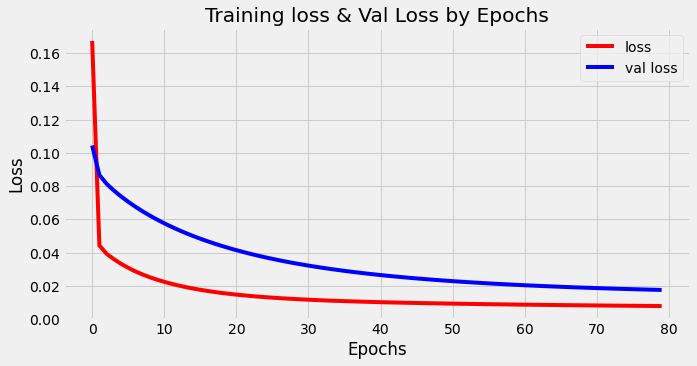

<Figure size 720x360 with 0 Axes>

In [47]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(loss)) 


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r',label='loss')
plt.plot(epochs,val_loss,'blue',label='val loss')
plt.title('Training loss & Val Loss by Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.figure()

In [49]:
y_predTU = TUGRU_model.predict(X_test)
y_predTU

1/1 [==============================] - 1s 643ms/step


array([[ 0.04824217],
       [ 0.05082344],
       [ 0.0773534 ],
       [ 0.05256915],
       [ 0.02349664],
       [ 0.00481463],
       [-0.01243622],
       [-0.0436012 ],
       [-0.08267843],
       [-0.09199539],
       [-0.08426716],
       [-0.08951563],
       [-0.10581566],
       [-0.10461169],
       [-0.1125639 ],
       [-0.14406744],
       [-0.15109095],
       [-0.04050969],
       [ 0.05603454],
       [ 0.05110808],
       [ 0.00061964],
       [ 0.00757159]], dtype=float32)

In [50]:
y_predTU.reshape(1,-1)

array([[ 0.04824217,  0.05082344,  0.0773534 ,  0.05256915,  0.02349664,
         0.00481463, -0.01243622, -0.0436012 , -0.08267843, -0.09199539,
        -0.08426716, -0.08951563, -0.10581566, -0.10461169, -0.1125639 ,
        -0.14406744, -0.15109095, -0.04050969,  0.05603454,  0.05110808,
         0.00061964,  0.00757159]], dtype=float32)

###Invert Transformed Tuned Data

In [51]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_predTU.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[338.29688 339.32938 349.94138 340.02768 328.39865 320.92584 314.0255
  301.5595  285.92862 282.20184 285.29312 283.19376 276.67374 277.15533
  273.97446 261.37302 258.5636  302.7961  341.41382 339.44324 319.24786
  322.02863]]


In [52]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [53]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [54]:
TU_GRU_Pred = y_pred_inv.flatten()   #y_pred_inv = TU_GRU_Pred
TU_GRU_Pred

array([338.29688, 339.32938, 349.94138, 340.02768, 328.39865, 320.92584,
       314.0255 , 301.5595 , 285.92862, 282.20184, 285.29312, 283.19376,
       276.67374, 277.15533, 273.97446, 261.37302, 258.5636 , 302.7961 ,
       341.41382, 339.44324, 319.24786, 322.02863], dtype=float32)

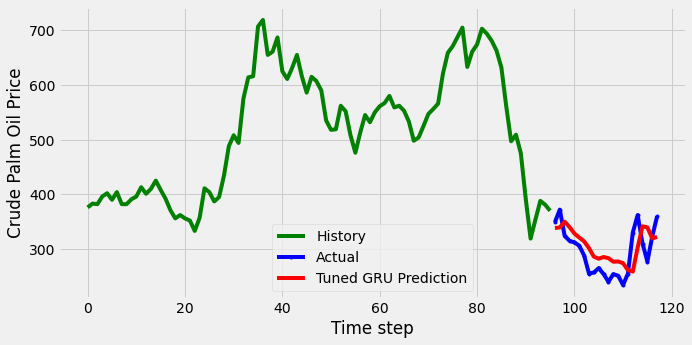

In [55]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), TU_GRU_Pred, color='red', label="Tuned GRU Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
plt.show();

In [56]:
TUMAE_GRU = mean_absolute_error(y_test_inv, TU_GRU_Pred)
print('MAE value of the GRU Model is:', TUMAE_GRU)

TUMDA_GRU = mda(y_test_inv, TU_GRU_Pred)
print('MDA value of the tuned GRU Model is:', TUMDA_GRU)

TUMAPE_GRU = mean_absolute_percentage_error(y_test_inv, TU_GRU_Pred)
print('MAPE value of the tuned GRU Model is:', TUMAPE_GRU)

TURMSE_GRU = mean_squared_error(y_test_inv,TU_GRU_Pred, squared=False)
print('RMSE value of the tuned GRU Model is:', TURMSE_GRU)

TUMSE_GRU = mean_squared_error(y_test_inv,TU_GRU_Pred)
print('MSE value of the tuned GRU Model is:', TUMSE_GRU)

MAE value of the GRU Model is: 30.92122996937145
MDA value of the tuned GRU Model is: 0.5238095238095238
MAPE value of the tuned GRU Model is: 10.66418545838924
RMSE value of the tuned GRU Model is: 35.408478881784056
MSE value of the tuned GRU Model is: 1253.7603767217477


Compare tuned GRU Actual VS Predicted (Zoomed-IN)

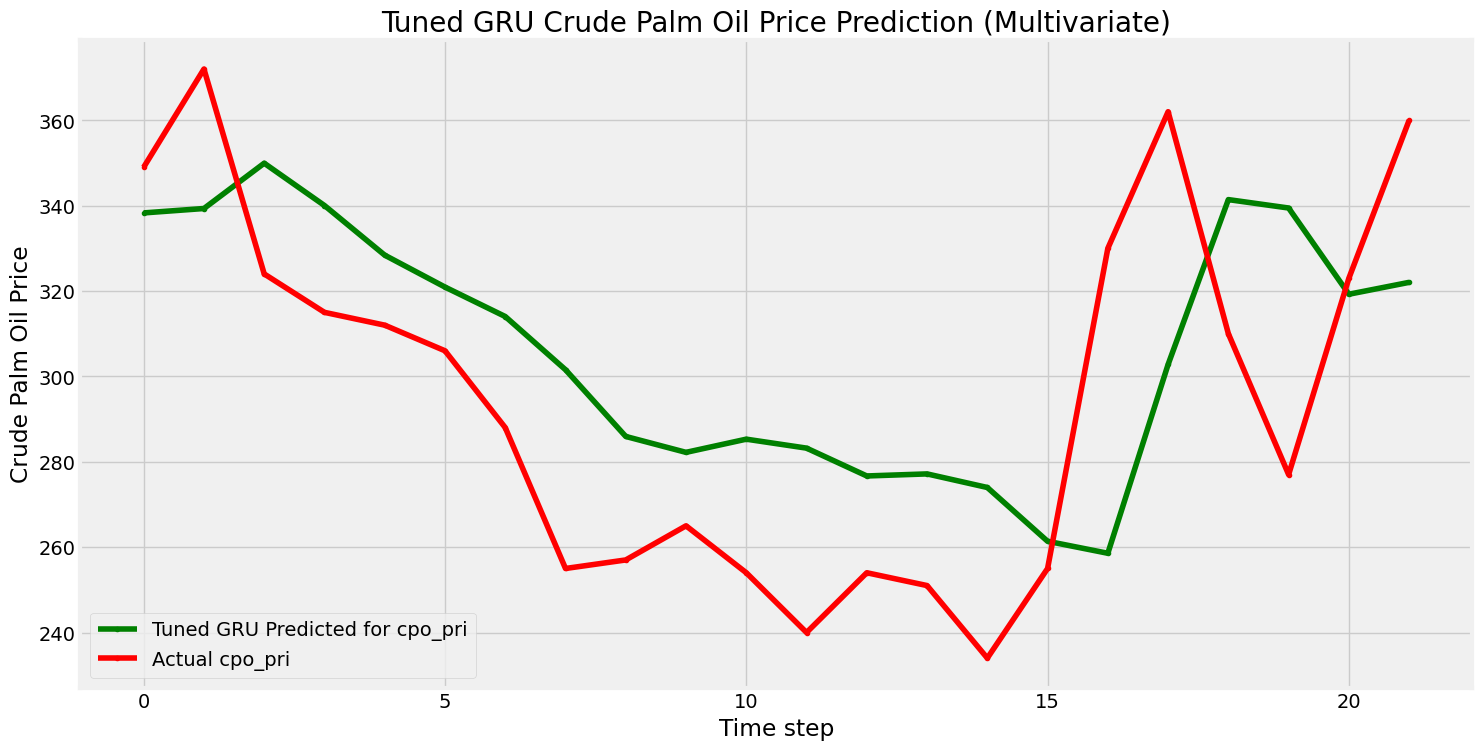

<Figure size 720x360 with 0 Axes>

In [57]:
#Plot the graph between actual vs predicted values
#plt.figure(figsize=(15,7))  #(10,6))
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(TU_GRU_Pred, color= 'green',marker='.',label = 'Tuned GRU Predicted for cpo_pri')
plt.plot(y_test_inv, color = 'red',marker='.',label = 'Actual cpo_pri ')
plt.title("Tuned GRU Crude Palm Oil Price Prediction (Multivariate)")
plt.xlabel("Time step")
plt.ylabel("Crude Palm Oil Price")
plt.legend()
plt.show()
plt.savefig('graph_TUGRU.png')

The tuned GRU is superior to the basseline based on the RSME result